In [15]:
import datetime

from pyspark.sql import SparkSession, Window
from pyspark.sql.types import StructType, StructField, StringType, TimestampType, FloatType
from pyspark.sql import functions as F
from pyspark.ml.clustering import KMeans
from pyspark.ml.linalg import Vectors, VectorUDT

In [2]:
spark = SparkSession.builder.config("spark.driver.memory", "15G").getOrCreate()

In [3]:
spark

# Convert CSV to Parquet

In [4]:
schema = StructType([
    StructField("LCLid",                   StringType(),    False),
    StructField("stdorToU",                StringType(),    False),
    StructField("DateTime",                TimestampType(), False),
    StructField("KWH/hh (per half hour) ", FloatType(),     False),
    StructField("Acorn",                   StringType(),    False),
    StructField("Acorn_grouped",           StringType(),    False),
])

In [64]:
(
    spark
    .read
    .format("csv")
    .option("header", True)
    .schema(schema)
    .load("../../data/raw/low-carbon-london/*.csv")
    .withColumnRenamed("LCLid", "meter_id")
    .withColumnRenamed("stdorToU", "stdortou")
    .withColumnRenamed("DateTime", "dt")
    .withColumnRenamed("KWH/hh (per half hour) ", "kwh")
    .withColumnRenamed("Acorn", "acorn")
    .withColumnRenamed("Acorn_grouped", "acorn_grouped")
    .write
    .format("parquet")
    .save("../../data/processed/low-carbon-london-2.parquet")
)

# Load Parquet Dataset

In [84]:
df = (
    spark
    .read
    .format("parquet")
    .load("../../data/processed/low-carbon-london.parquet")
)

## Separate in-sample from out-of-sample

In [103]:
pc = 0.95

(
    df
    .withColumn("month", F.month("dt"))
    .groupby("meter_id", "month")
    .agg({"month": "count"})
    .filter(
        (F.col("month") == 1)  & (F.col("count(month)") > round(31 * 48 * pc)) |
        (F.col("month") == 2)  & (F.col("count(month)") > round(28 * 48 * pc)) |
        (F.col("month") == 3)  & (F.col("count(month)") > round(31 * 48 * pc)) |
        (F.col("month") == 4)  & (F.col("count(month)") > round(30 * 48 * pc)) |
        (F.col("month") == 5)  & (F.col("count(month)") > round(31 * 48 * pc)) |
        (F.col("month") == 6)  & (F.col("count(month)") > round(30 * 48 * pc)) |
        (F.col("month") == 7)  & (F.col("count(month)") > round(31 * 48 * pc)) |
        (F.col("month") == 8)  & (F.col("count(month)") > round(31 * 48 * pc)) |
        (F.col("month") == 9)  & (F.col("count(month)") > round(30 * 48 * pc)) |
        (F.col("month") == 10) & (F.col("count(month)") > round(31 * 48 * pc)) |
        (F.col("month") == 11) & (F.col("count(month)") > round(30 * 48 * pc)) |
        (F.col("month") == 12) & (F.col("count(month)") > round(31 * 48 * pc))
    )
    .groupby("meter_id")
    .agg({"month": "count"})
    .filter("count(month) == 12")
    .show()
)

+---------+------------+
| meter_id|count(month)|
+---------+------------+
|MAC005232|          12|
|MAC000041|          12|
|MAC005439|          12|
|MAC002980|          12|
|MAC001761|          12|
|MAC005122|          12|
|MAC003083|          12|
|MAC003509|          12|
|MAC004029|          12|
|MAC001430|          12|
|MAC002560|          12|
|MAC005271|          12|
|MAC000925|          12|
|MAC005303|          12|
|MAC000976|          12|
|MAC004358|          12|
|MAC001803|          12|
|MAC004897|          12|
|MAC004532|          12|
|MAC004692|          12|
+---------+------------+
only showing top 20 rows



In [6]:
n_slots_required = 365 * 0.95 * 48  # 95% of 1 year

In [7]:
sampletype = (
    df
    .groupby("meter_id")
    .agg({"kwh": "count"})
    .withColumn("insample", F.col("count(kwh)") >= n_slots_required)
    .drop("count(kwh)")
)

In [8]:
sampletype.groupby("insample").count().show()

+--------+-----+
|insample|count|
+--------+-----+
|    true| 5400|
|   false|  166|
+--------+-----+



## Write in-sample and out-of-sample to local filesystem

In [9]:
(
    df
    .join(sampletype, on="meter_id")
    .filter(F.col("insample") == True)
    .write
    .format("parquet")
    .save("../../data/processed/insample.parquet")
)

In [10]:
(
    df
    .join(sampletype, on="meter_id")
    .filter(F.col("insample") == False)
    .write
    .format("parquet")
    .save("../../data/processed/outofsample.parquet")
)

In [11]:
df_ins = spark.read.format("parquet").load("../../data/processed/insample.parquet")
df_oos = spark.read.format("parquet").load("../../data/processed/outofsample.parquet")

# Apply per-meter MinMax scaling to dataset

In [12]:
insample_norm_path = "../../data/processed/insample-norm.parquet"

In [13]:
(
    df_ins
    .dropna(subset=["kwh"])
    .join(df_ins.groupby("meter_id").max("kwh"), on="meter_id")
    .withColumn("load_factor", F.col("kwh") / F.col("max(kwh)"))
    .select("meter_id", "dt", "load_factor")
    .write
    .format("parquet")
    .save(insample_norm_path)
)

In [14]:
df_ins_norm = spark.read.format("parquet").load(insample_norm_path)

# Convert to wide format

In [7]:
slots = [
    datetime.time(i // 2, i % 2 * 30).strftime("%H:%M")
    for i in range(48)
]

In [6]:
df_ins_norm_wide_path = "../../data/processed/insample-norm-wide.parquet"

In [26]:
(
    df_ins_norm
    .withColumn("date", F.to_date("dt"))
    .withColumn("time", F.concat_ws(":", F.lpad(F.hour("dt"), 2, "0"), F.lpad(F.minute("dt"), 2, "0")))
    .groupby("meter_id", "date")
    .pivot("time", values=slots)
    .agg(F.first("load_factor"))
    .write
    .format("parquet")
    .save(df_ins_norm_wide_path)
)

In [8]:
df_ins_norm_wide = spark.read.format("parquet").load(df_ins_norm_wide_path)

# Create feature vector and train KMeans model

In [5]:
sample_idx = [
    "MAC000032",
    "MAC000041",
    "MAC000338",
    "MAC000925",
    "MAC000976",
    "MAC001430",
    "MAC001761",
    "MAC001803",
    "MAC002560",
    "MAC002980",
    "MAC003083",
    "MAC003509",
    "MAC004029",
    "MAC004358",
    "MAC004532",
    "MAC004692",
    "MAC004897",
    "MAC005122",
    "MAC005232",
    "MAC005271",
]

In [3]:
path_feature_vector = "../../data/processed/insample-feature-vector.parquet"

In [4]:
avg_slots = [
    "avg(%s)" % datetime.time(i // 2, i % 2 * 30).strftime("%H:%M")
    for i in range(48)
]

In [21]:
list_to_vector_udf = F.udf(lambda l: Vectors.dense(l), VectorUDT())

In [23]:
df_ins_norm_wide

DataFrame[meter_id: string, date: date, 00:00: double, 00:30: double, 01:00: double, 01:30: double, 02:00: double, 02:30: double, 03:00: double, 03:30: double, 04:00: double, 04:30: double, 05:00: double, 05:30: double, 06:00: double, 06:30: double, 07:00: double, 07:30: double, 08:00: double, 08:30: double, 09:00: double, 09:30: double, 10:00: double, 10:30: double, 11:00: double, 11:30: double, 12:00: double, 12:30: double, 13:00: double, 13:30: double, 14:00: double, 14:30: double, 15:00: double, 15:30: double, 16:00: double, 16:30: double, 17:00: double, 17:30: double, 18:00: double, 18:30: double, 19:00: double, 19:30: double, 20:00: double, 20:30: double, 21:00: double, 21:30: double, 22:00: double, 22:30: double, 23:00: double, 23:30: double]

In [119]:
df_feature_vector = (
    # start with a wide representation of our data
    df_ins_norm_wide
    
    # add daytype and month columns to our dataset for grouping
    .withColumn("daytype", F.when(F.dayofweek("date").isin([1, 7]), "WE").otherwise("BUS"))
    .withColumn("month", F.month("date"))
    
    # calculate the average monthly load curve for each meter and daytype
    .groupby("meter_id", "daytype", "month")
    .mean(*slots)
    
    # transform our slot columns into a single array column
    .select("meter_id", "daytype", "month", F.array(*avg_slots).alias("c"))
    
    # sort everything so that when we concat arrays they are
    # in the correct order
    .orderBy("meter_id", "daytype", "month")
    
    # concat our mean load curves into a single array
    .groupby("meter_id")
    .agg(F.flatten(F.collect_list("c")).alias("features"))
    
    # cast our features column into a DenseVector type
    .select("meter_id", list_to_vector_udf("features").alias("features"))

    # remove these guys with not enough records (TODO: do in sampling step)
    .filter("meter_id not in ('MAC005492', 'MAC002597')")
#     .select("meter_id", F.size("features").alias("lenfeat"))
#     .show()
)

In [118]:
df_feature_vector.select(F.size("features").alias("lenfeat")).distinct().show()

+-------+
|lenfeat|
+-------+
|   1152|
+-------+



In [62]:
import pandas as pd

sample_1 = (
    df_ins_norm_wide
    .filter("meter_id == 'MAC002597'")
    .toPandas()
    .assign(date=pd.to_datetime(sample_1.date))
    .sort_values("date")
    .assign(month=lambda x: x.date.dt.month)
    .reset_index(drop=True)
)

In [63]:
sample_1.groupby("month").date.count()

month
1     62
2     56
3     31
4      4
7     44
8     62
9     60
10    62
11    60
12    62
Name: date, dtype: int64

In [70]:
sample_1.date.describe()

<ipython-input-70-3bfb8395d45f>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  sample_1.date.describe()


count                     503
unique                    503
top       2013-12-05 00:00:00
freq                        1
first     2012-07-10 00:00:00
last      2014-02-28 00:00:00
Name: date, dtype: object

In [72]:
sample_1[sample_1.date >= "2013-04-01"].head()

,meter_id,date,00:00,00:30,01:00,01:30,02:00,02:30,03:00,03:30,...,19:30,20:00,20:30,21:00,21:30,22:00,22:30,23:00,23:30,month
265,MAC002597,2013-04-01,0.016367,0.015312,0.011088,0.011088,0.011088,0.011088,0.011088,0.010560,...,0.051214,0.021119,0.019535,0.019007,0.020591,0.019535,0.565470,0.290391,0.046463,4
266,MAC002597,2013-04-02,0.046463,0.045935,0.046990,0.046990,0.046990,0.045935,0.015839,0.013728,...,0.016895,0.079725,0.049630,0.019535,0.017951,0.019535,0.020063,0.017951,0.016895,4
267,MAC002597,2013-04-03,0.016367,0.014256,0.015839,0.016895,0.016895,0.016895,0.016895,0.021119,...,0.009504,0.008976,0.007920,0.007920,0.068638,0.026927,0.023759,0.022175,0.018479,4
268,MAC002597,2013-04-04,0.021647,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
269,MAC002597,2013-07-10,NaN,0.073390,0.063886,0.019535,0.005280,0.021647,0.000000,0.016895,...,0.024815,0.003696,0.049102,0.035903,0.021647,0.035903,0.032207,0.021647,0.045407,7


/Users/henryehly/src/low-carbon-london/.venv/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


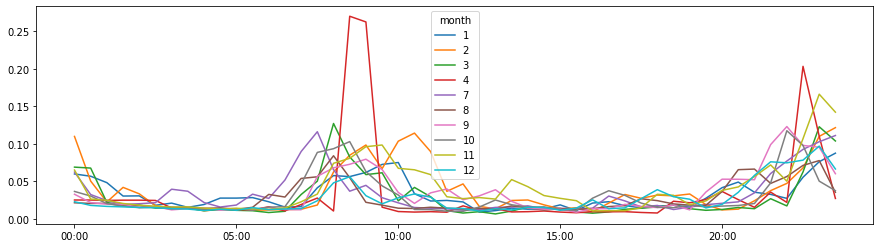

In [83]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=(15, 4))
sample_1.groupby("month")[slots].mean().T.plot(ax=ax)

plt.show()

In [ ]:
# +--------------+
# |size(features)|
# +--------------+
# |          1056|
# |           912|
# |          1152|
# +--------------+

In [120]:
kmeans = KMeans(k=9, featuresCol="features")
kmeans.setSeed(1)

KMeans_be5fbd6ad9d6

In [121]:
df_feature_vector.show()

+---------+--------------------+
| meter_id|            features|
+---------+--------------------+
|MAC000032|[0.53495510360781...|
|MAC000041|[0.15674432925709...|
|MAC000338|[0.06985207884214...|
|MAC000925|[0.06952979936340...|
|MAC000976|[0.03878805744912...|
|MAC001430|[0.09760969092946...|
|MAC001761|[0.09663108803997...|
|MAC001803|[0.01054270570701...|
|MAC002560|[0.08773383626408...|
|MAC002980|[0.12055694325014...|
|MAC003083|[0.02694927111204...|
|MAC003509|[0.03287211738539...|
|MAC004029|[0.12783493416433...|
|MAC004358|[0.04828897139205...|
|MAC004532|[0.07611219775890...|
|MAC004692|[0.07735540075419...|
|MAC004897|[0.64797426084074...|
|MAC005122|[0.13781342022964...|
|MAC005232|[0.01592042640346...|
|MAC005271|[0.03910530191387...|
+---------+--------------------+
only showing top 20 rows



In [107]:
# perhaps NaN values exist? maybe this causes error
model = kmeans.fit(df_feature_vector)

IllegalArgumentException: requirement failed

In [95]:
centers = np.array(model.clusterCenters()); centers.shape

In [40]:
import numpy as np

In [45]:
import matplotlib
import matplotlib.pyplot as plt

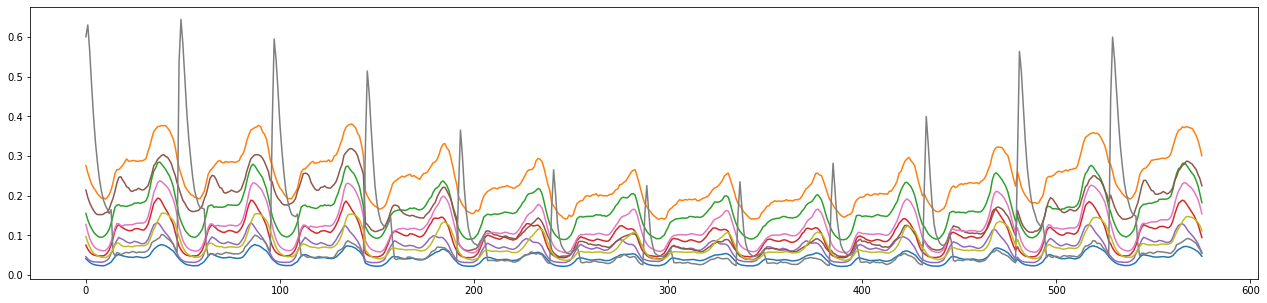

In [103]:
fig, ax = plt.subplots(figsize=(22, 5))

for i in range(centers.shape[0]):
    ax.plot(centers[i][:12 * 48], label=i)

plt.show()

In [ ]:
# if you just wanna check shape, consider a distance metric that cancels out height differences